In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def generate_result(auc_b_c, auc_b_light, auc_c_light, label=""):
    result = {}
    result['b vs c'] = [auc_b_c]
    result['b vs light'] = [auc_b_light]
    result['c vs light'] = [auc_c_light]
    result['name'] = [label]
    return pandas.DataFrame(result)

In [3]:
import root_numpy
import pandas
import numpy
from rep.data import LabeledDataStorage
#from hep_ml.decisiontrain import DecisionTrainClassifier, DecisionTrainRegressor
from hep_ml.losses import LogLossFunction, MSELossFunction
from rep.metaml import FoldingClassifier, FoldingRegressor
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier
from rep.estimators import XGBoostClassifier, SklearnClassifier

## Read data

In [4]:
treename = 'tag'

data_b = pandas.DataFrame(root_numpy.root2array('datasets/type=5.root', treename=treename)).dropna()
data_b = data_b[::90]
data_c = pandas.DataFrame(root_numpy.root2array('datasets/type=4.root', treename=treename)).dropna()
data_light = pandas.DataFrame(root_numpy.root2array('datasets/type=0.root', treename=treename)).dropna()
data_light = data_light[::2]

In [5]:
data = {'b': data_b, 'c': data_c, 'light': data_light}

In [6]:
full_data = pandas.concat([data_b, data_c, data_light])
full_data['label'] = [0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light)

In [7]:
jet_features = [column for column in data_b.columns if "Jet" in column]
sv_features = [column for column in data_b.columns if "SV" in column]

# Multiclassification

## Data preprocessing

In [8]:
train_data = full_data[sv_features].values
labels = full_data['label'].values

## Train

In [9]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=8, 
                             subsample=0.5, max_depth=8)
# xgb_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time multi_folding.fit(train_data, labels)

CPU times: user 5min, sys: 37.7 s, total: 5min 38s
Wall time: 2min 14s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8'],
         n_folds=2, parallel_profile=None, random_state=11)

In [10]:
multi_probs = multi_folding.predict_proba(train_data)

KFold prediction using folds column


## Results

In [11]:
labels = numpy.array([0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light))
multiclass_result = generate_result(1 - roc_auc_score(labels > 0, multi_probs[:, 0] / multi_probs[:, 1], 
                                                      sample_weight=(labels != 2) * 1),
                                    1 - roc_auc_score(labels > 1, multi_probs[:, 0] / multi_probs[:, 2],
                                                      sample_weight=(labels != 1) * 1),
                                    1 - roc_auc_score(labels > 1, multi_probs[:, 1] / multi_probs[:, 2],
                                                      sample_weight=(labels != 0) * 1),
                                    label='multiclass')

In [12]:
result = pandas.concat([multiclass_result])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
multiclass,0.949619,0.984022,0.973779


# Multiclassification + PCA

## Data preprocessing

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=train_data.shape[1])
pca_train_data = pca.fit_transform(train_data)

## Train

In [14]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=8, 
                             subsample=0.5, max_depth=8)
# xgb_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
pca_multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time pca_multi_folding.fit(pca_train_data, labels)

CPU times: user 5min 27s, sys: 37.9 s, total: 6min 5s
Wall time: 2min 31s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8'],
         n_folds=2, parallel_profile=None, random_state=11)

In [15]:
pca_multi_probs = pca_multi_folding.predict_proba(pca_train_data)

KFold prediction using folds column


## Results

In [16]:
labels = numpy.array([0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light))
pca_multiclass_result = generate_result(1 - roc_auc_score(labels > 0, pca_multi_probs[:, 0] / pca_multi_probs[:, 1], 
                                                      sample_weight=(labels != 2) * 1),
                                    1 - roc_auc_score(labels > 1, pca_multi_probs[:, 0] / pca_multi_probs[:, 2],
                                                      sample_weight=(labels != 1) * 1),
                                    1 - roc_auc_score(labels > 1, pca_multi_probs[:, 1] / pca_multi_probs[:, 2],
                                                      sample_weight=(labels != 0) * 1),
                                    label='pca_multiclass')

In [17]:
result = pandas.concat([multiclass_result, pca_multiclass_result])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
multiclass,0.949619,0.984022,0.973779
pca_multiclass,0.945084,0.985338,0.977082


# Multiclassification + Standardization + PCA

## Data preprocessing

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=train_data.shape[1])
std_train_data = StandardScaler().fit_transform(train_data)
std_pca_train_data = pca.fit_transform(std_train_data)

## Train

In [19]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=8, 
                             subsample=0.5, max_depth=8)
# xgb_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
std_pca_multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time std_pca_multi_folding.fit(std_pca_train_data, labels)

CPU times: user 5min 45s, sys: 38.3 s, total: 6min 23s
Wall time: 2min 41s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8'],
         n_folds=2, parallel_profile=None, random_state=11)

In [20]:
std_pca_multi_probs = std_pca_multi_folding.predict_proba(std_pca_train_data)

KFold prediction using folds column


## Results

In [21]:
labels = numpy.array([0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light))
std_pca_multiclass_result = generate_result(1 - roc_auc_score(labels > 0, std_pca_multi_probs[:, 0] / std_pca_multi_probs[:, 1], 
                                                      sample_weight=(labels != 2) * 1),
                                    1 - roc_auc_score(labels > 1, std_pca_multi_probs[:, 0] / std_pca_multi_probs[:, 2],
                                                      sample_weight=(labels != 1) * 1),
                                    1 - roc_auc_score(labels > 1, std_pca_multi_probs[:, 1] / std_pca_multi_probs[:, 2],
                                                      sample_weight=(labels != 0) * 1),
                                    label='std_pca_multiclass')

In [22]:
result = pandas.concat([multiclass_result, pca_multiclass_result, std_pca_multiclass_result])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
multiclass,0.949619,0.984022,0.973779
pca_multiclass,0.945084,0.985338,0.977082
std_pca_multiclass,0.941354,0.970078,0.957195


# Combination of multiclass and pca mupliclass

In [23]:
comb_multi_probs = 0.5 * (pca_multi_probs + multi_probs)

In [24]:
labels = numpy.array([0] * len(data_b) + [1] * len(data_c) + [2] * len(data_light))
comb_multiclass_result = generate_result(1 - roc_auc_score(labels > 0, comb_multi_probs[:, 0] / comb_multi_probs[:, 1], 
                                                      sample_weight=(labels != 2) * 1),
                                    1 - roc_auc_score(labels > 1, comb_multi_probs[:, 0] / comb_multi_probs[:, 2],
                                                      sample_weight=(labels != 1) * 1),
                                    1 - roc_auc_score(labels > 1, comb_multi_probs[:, 1] / comb_multi_probs[:, 2],
                                                      sample_weight=(labels != 0) * 1),
                                    label='comb_multiclass')

In [25]:
result = pandas.concat([multiclass_result, pca_multiclass_result, comb_multiclass_result])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
multiclass,0.949619,0.984022,0.973779
pca_multiclass,0.945084,0.985338,0.977082
comb_multiclass,0.949374,0.985385,0.976605


# Multiclass + features generation + pca dim reduction

## Data preprocessing

In [26]:
full_data['log_SVFDChi2'] = numpy.log(full_data['SVFDChi2'].values)
full_data['log_SVSumIPChi2'] = numpy.log(full_data['SVSumIPChi2'].values)
full_data['P_Sin'] = 0.5*full_data['SVMC'].values - (full_data['SVM'].values)**2/(2.*full_data['SVMC'].values)
full_data['Psv'] = full_data['SVPT'].values * full_data['P_Sin'].values
full_data['Psv2'] = full_data['P_Sin'].values / full_data['SVPT'].values
full_data['Mt'] = full_data['SVMC'].values - full_data['P_Sin'].values
full_data['QtoN'] = 1. * full_data['SVQ'].values / full_data['SVN'].values
    
new_features = ['log_SVFDChi2', 'log_SVSumIPChi2', 'P_Sin', 'Psv', 'Psv2', 'Mt', 'QtoN']

In [27]:
features = []
for ind1 in range(0, len(sv_features)):
    f1 = sv_features[ind1]
    for ind2 in range(ind1, len(sv_features)):
        f2 = sv_features[ind2]
        
        full_data[f1+'_mult_'+f2] = full_data[f1].values * full_data[f2].values
        full_data[f1+'_div_'+f2] = full_data[f1].values / (full_data[f2].values + 0.1)
        full_data[f2+'_div_'+f1] = full_data[f2].values / (full_data[f1].values + 0.1)
        features.append(f1+'_mult_'+f2)
        features.append(f1+'_div_'+f2)
        features.append(f2+'_div_'+f1)

        full_data['2'+f1+'_plus_'+f2] = (full_data[f1].values**2) + (full_data[f2].values**2)
        full_data['2'+f1+'_min_'+f2] = (full_data[f1].values**2) - (full_data[f2].values**2)
        features.append('2'+f1+'_plus_'+f2)
        features.append('2'+f1+'_min_'+f2)
        
new_features += features

In [28]:
new_train_data = full_data[sv_features + new_features].values

In [56]:
def get_result(proba, labels, name="result"):
    result = generate_result(1 - roc_auc_score(labels > 0, proba[:, 0] / proba[:, 1], 
                                                      sample_weight=(labels != 2) * 1),
                                    1 - roc_auc_score(labels > 1, proba[:, 0] / proba[:, 2],
                                                      sample_weight=(labels != 1) * 1),
                                    1 - roc_auc_score(labels > 1, proba[:, 1] / proba[:, 2],
                                                      sample_weight=(labels != 0) * 1),
                                    label=name)
    return result

In [43]:
mean_roc_aucs = []
ns = []

for i in range(10, new_train_data.shape[1], 10):

    pca = PCA(n_components= i)
    pca_new_train_data = pca.fit_transform(new_train_data)
    
    forest = ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=2)
    new_multi_folding = FoldingClassifier(forest, n_folds=2, random_state=11)
    new_multi_folding.fit(pca_new_train_data, labels)
    
    pca_new_multi_probs = new_multi_folding.predict_proba(pca_new_train_data)
    
    metric = get_result(pca_new_multi_probs, labels, '').values[0, 0:3].mean()
    
    mean_roc_aucs.append(metric)
    ns.append(i)


KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


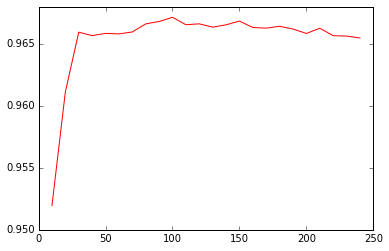

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(ns, mean_roc_aucs)
plt.show()

In [50]:
ns = numpy.array(ns)
mean_roc_aucs = numpy.array(mean_roc_aucs)

ndim = ns[mean_roc_aucs == mean_roc_aucs.max()][0]
print ndim

100


In [51]:
pca = PCA(n_components= ndim)
pca_new_train_data = pca.fit_transform(new_train_data)

## Train

In [52]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=8, 
                             subsample=0.5, max_depth=8)
# xgb_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
pca_new_multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time pca_new_multi_folding.fit(pca_new_train_data, labels)

CPU times: user 50min 6s, sys: 1min 21s, total: 51min 27s
Wall time: 16min 11s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20', 'Featu...', 'Feature_93', 'Feature_94', 'Feature_95', 'Feature_96', 'Feature_97', 'Feature_98', 'Feature_99'],
         n_folds=2, parallel_profile=None, random_state=11)

In [53]:
pca_new_multi_probs = pca_new_multi_folding.predict_proba(pca_new_train_data)

KFold prediction using folds column


## Results

In [57]:
pca_new_multi_results = get_result(pca_new_multi_probs, labels, "pca_new_multiclass")

In [58]:
result = pandas.concat([multiclass_result, pca_multiclass_result, comb_multiclass_result, pca_new_multi_results])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
multiclass,0.949619,0.984022,0.973779
pca_multiclass,0.945084,0.985338,0.977082
comb_multiclass,0.949374,0.985385,0.976605
pca_new_multiclass,0.948460,0.988040,0.980934


# Multiclass + features generation + features selection

## Data preprocessing

In [60]:
full_data_lds = LabeledDataStorage(full_data, labels)

In [61]:
forest = ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=2)
feature_list, score_list = \
MyRFECV(estimator=forest, step=10, cv=2, features=numpy.array(sv_features+new_features)).fit(full_data_lds)

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


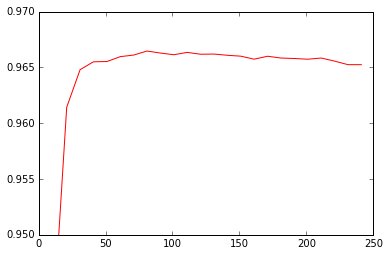

In [69]:
length = numpy.array([len(fs) for fs in feature_list])
plt.plot(length, score_list)
plt.ylim(0.95, 0.97)
plt.show()

In [70]:
sel_features = feature_list[score_list == score_list.max()][0]
len(sel_features)

81

In [71]:
sel_new_train_data = full_data[sel_features].values

## Train

In [72]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=8, 
                             subsample=0.5, max_depth=8)
# xgb_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
sel_new_multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time sel_new_multi_folding.fit(sel_new_train_data, labels)

CPU times: user 37min 33s, sys: 1min 10s, total: 38min 44s
Wall time: 13min 8s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20', 'Featu...', 'Feature_74', 'Feature_75', 'Feature_76', 'Feature_77', 'Feature_78', 'Feature_79', 'Feature_80'],
         n_folds=2, parallel_profile=None, random_state=11)

In [73]:
sel_new_multi_probs = sel_new_multi_folding.predict_proba(sel_new_train_data)

KFold prediction using folds column


## Results

In [74]:
sel_new_multi_results = get_result(sel_new_multi_probs, labels, "sel_new_multiclass")

In [75]:
result = pandas.concat([multiclass_result, 
                        pca_multiclass_result, 
                        comb_multiclass_result, 
                        pca_new_multi_results, 
                        sel_new_multi_results])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
multiclass,0.949619,0.984022,0.973779
pca_multiclass,0.945084,0.985338,0.977082
comb_multiclass,0.949374,0.985385,0.976605
pca_new_multiclass,0.948460,0.988040,0.980934
sel_new_multiclass,0.950740,0.988008,0.980507


# Multiclass + features generation + features selection + PCA

## Data preprocessing

In [78]:
from sklearn.decomposition import PCA

pca = PCA(n_components=sel_new_train_data.shape[1])
pca_sel_new_train_data = pca.fit_transform(sel_new_train_data)

## Train

In [79]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=8, 
                             subsample=0.5, max_depth=8)
# xgb_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
pca_sel_new_multi_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time pca_sel_new_multi_folding.fit(pca_sel_new_train_data, labels)

CPU times: user 35min 2s, sys: 1min 14s, total: 36min 17s
Wall time: 12min 39s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20', 'Featu...', 'Feature_74', 'Feature_75', 'Feature_76', 'Feature_77', 'Feature_78', 'Feature_79', 'Feature_80'],
         n_folds=2, parallel_profile=None, random_state=11)

In [80]:
pca_sel_new_multi_probs = pca_sel_new_multi_folding.predict_proba(pca_sel_new_train_data)

KFold prediction using folds column


## Results

In [81]:
pca_sel_new_multi_results = get_result(pca_sel_new_multi_probs, labels, "pca_sel_new_multiclass")

In [82]:
result = pandas.concat([multiclass_result, 
                        pca_multiclass_result, 
                        comb_multiclass_result, 
                        pca_new_multi_results, 
                        sel_new_multi_results,
                        pca_sel_new_multi_results])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
multiclass,0.949619,0.984022,0.973779
pca_multiclass,0.945084,0.985338,0.977082
comb_multiclass,0.949374,0.985385,0.976605
pca_new_multiclass,0.948460,0.988040,0.980934
sel_new_multiclass,0.950740,0.988008,0.980507
pca_sel_new_multiclass,0.949188,0.988429,0.980726


# Cambination

## Results

In [86]:
comb2_multi_results = 1./4. * (pca_sel_new_multi_probs + 
                               sel_new_multi_probs + 
                               pca_multi_probs + 
                               pca_new_multi_probs)

In [87]:
comb2_multi_results = get_result(comb2_multi_results, labels, "comb2_multiclass")

In [88]:
result = pandas.concat([multiclass_result, 
                        pca_multiclass_result, 
                        comb_multiclass_result, 
                        pca_new_multi_results, 
                        sel_new_multi_results,
                        pca_sel_new_multi_results,
                        comb2_multi_results])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
multiclass,0.949619,0.984022,0.973779
pca_multiclass,0.945084,0.985338,0.977082
comb_multiclass,0.949374,0.985385,0.976605
pca_new_multiclass,0.948460,0.988040,0.980934
sel_new_multiclass,0.950740,0.988008,0.980507
pca_sel_new_multiclass,0.949188,0.988429,0.980726
comb2_multiclass,0.950432,0.988212,0.980862


# One vs All + features generation + features selection

## Data preprocessing

In [95]:
b_vs_all_labels = (labels == 0) * 1
c_vs_all_labels = (labels == 1) * 1
light_vs_all_labels = (labels == 2) * 1

## Train

### b vs all

In [96]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=8, 
                             subsample=0.5, max_depth=8)
# xgb_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
b_vs_all_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time b_vs_all_folding.fit(sel_new_train_data, b_vs_all_labels)

CPU times: user 25min 16s, sys: 47 s, total: 26min 3s
Wall time: 8min 40s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20', 'Featu...', 'Feature_74', 'Feature_75', 'Feature_76', 'Feature_77', 'Feature_78', 'Feature_79', 'Feature_80'],
         n_folds=2, parallel_profile=None, random_state=11)

In [98]:
b_vs_all_probas = b_vs_all_folding.predict_proba(sel_new_train_data)

KFold prediction using folds column


### c vs all

In [99]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=8, 
                             subsample=0.5, max_depth=8)
# xgb_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
c_vs_all_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time c_vs_all_folding.fit(sel_new_train_data, c_vs_all_labels)

CPU times: user 24min 40s, sys: 46.5 s, total: 25min 26s
Wall time: 8min 27s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20', 'Featu...', 'Feature_74', 'Feature_75', 'Feature_76', 'Feature_77', 'Feature_78', 'Feature_79', 'Feature_80'],
         n_folds=2, parallel_profile=None, random_state=11)

In [100]:
c_vs_all_probas = c_vs_all_folding.predict_proba(sel_new_train_data)

KFold prediction using folds column


### light vs all

In [101]:
from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=8, 
                             subsample=0.5, max_depth=8)
# xgb_base = RandomForestClassifier(n_estimators=100, max_depth=None, max_features='auto')
light_vs_all_folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time light_vs_all_folding.fit(sel_new_train_data, light_vs_all_labels)

CPU times: user 24min 40s, sys: 46.2 s, total: 25min 26s
Wall time: 8min 29s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=8, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20', 'Featu...', 'Feature_74', 'Feature_75', 'Feature_76', 'Feature_77', 'Feature_78', 'Feature_79', 'Feature_80'],
         n_folds=2, parallel_profile=None, random_state=11)

In [102]:
light_vs_all_probas = light_vs_all_folding.predict_proba(sel_new_train_data)

KFold prediction using folds column


### probas

In [103]:
one_vs_all_probas = numpy.concatenate((b_vs_all_probas[:,[1]], c_vs_all_probas[:,[1]], light_vs_all_probas[:,[1]]), axis=1)
one_vs_all_probas = one_vs_all_probas/one_vs_all_probas.sum(axis=1, keepdims=True)

## Results

In [104]:
one_vs_all_results = get_result(one_vs_all_probas, labels, "one_vs_all")

In [105]:
result = pandas.concat([multiclass_result, 
                        pca_multiclass_result, 
                        comb_multiclass_result, 
                        pca_new_multi_results, 
                        sel_new_multi_results,
                        pca_sel_new_multi_results,
                        comb2_multi_results,
                        one_vs_all_results])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
multiclass,0.949619,0.984022,0.973779
pca_multiclass,0.945084,0.985338,0.977082
comb_multiclass,0.949374,0.985385,0.976605
pca_new_multiclass,0.948460,0.988040,0.980934
sel_new_multiclass,0.950740,0.988008,0.980507
pca_sel_new_multiclass,0.949188,0.988429,0.980726
comb2_multiclass,0.950432,0.988212,0.980862
one_vs_all,0.950171,0.987677,0.980033


# Combination 3

In [110]:
comb3_multi_results = 1./5. * (pca_sel_new_multi_probs + 
                               sel_new_multi_probs + 
                               pca_multi_probs + 
                               pca_new_multi_probs +
                               one_vs_all_probas)

In [111]:
comb3_multi_results = get_result(comb3_multi_results, labels, "comb3_multiclass")

In [112]:
result = pandas.concat([multiclass_result, 
                        pca_multiclass_result, 
                        comb_multiclass_result, 
                        pca_new_multi_results, 
                        sel_new_multi_results,
                        pca_sel_new_multi_results,
                        comb2_multi_results,
                        one_vs_all_results,
                        comb3_multi_results])
result.index = result['name']
result = result.drop('name', axis=1)
result

,b vs c,b vs light,c vs light
name,,,
multiclass,0.949619,0.984022,0.973779
pca_multiclass,0.945084,0.985338,0.977082
comb_multiclass,0.949374,0.985385,0.976605
pca_new_multiclass,0.948460,0.988040,0.980934
sel_new_multiclass,0.950740,0.988008,0.980507
pca_sel_new_multiclass,0.949188,0.988429,0.980726
comb2_multiclass,0.950432,0.988212,0.980862
one_vs_all,0.950171,0.987677,0.980033
comb3_multiclass,0.950753,0.988230,0.980877


# Features selection

In [33]:
class MyRFECV(object):
    
    def __init__(self, estimator, step, cv, features):
        self.estimator = estimator
        self.step = step
        self.cv = cv
        self.features = features
        
    def _score(self, labels, probs):
        roc_b_c = 1 - roc_auc_score(labels > 0, probs[:, 0] / probs[:, 1], sample_weight=(labels != 2) * 1)
        roc_b_light = 1 - roc_auc_score(labels > 1, probs[:, 0] / probs[:, 2], sample_weight=(labels != 1) * 1)
        roc_c_light = 1 - roc_auc_score(labels > 1, probs[:, 1] / probs[:, 2], sample_weight=(labels != 0) * 1)
        return (roc_b_c + roc_b_light + roc_c_light) / 3.
        
    def _fit_step(self, data, features):
        sk = SklearnClassifier(self.estimator, features=None)
        folding = FoldingClassifier(sk, n_folds=self.cv, random_state=11, features=features)
        folding.fit_lds(data)
        importances = folding.feature_importances_
        indices = numpy.argsort(importances)[::-1]
        
        labels = data.target
        probs = folding.predict_proba(data.data)
        score = self._score(labels, probs)
        
        return features[indices], score
        
    def fit(self, data):
        features = self.features
        feature_list = []
        score_list = []
        
        while len(features) >= self.step:
            features, score = self._fit_step(data, features)
            feature_list.append(features)
            score_list.append(score)
            
            features = features[:-self.step]
            
        if len(features) > 0:
            features, score = self._fit_step(data, features)
            feature_list.append(features)
            score_list.append(score)
            
        return numpy.array(feature_list), numpy.array(score_list)